## Two Asset with adjustment cost 
### Liquid vs Illiquid Assets

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import scipy.sparse as sparse
from scipy.sparse.linalg import inv
from time import time as tic
from scipy.stats import norm
import numpy.matlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

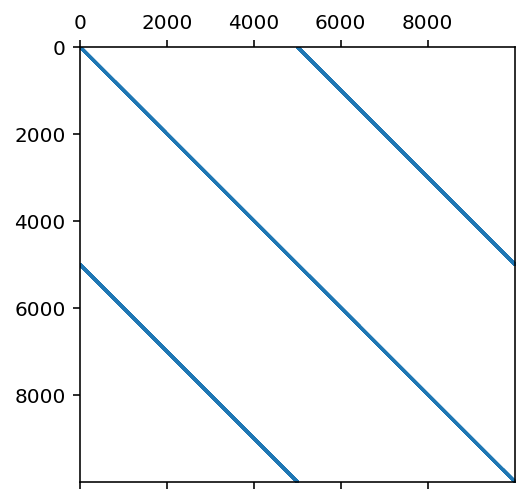

In [575]:
ga = 2 #CRRA utility with parameter gamma
ra = 0.05
rb_pos = 0.03
rb_neg = 0.12
rho = 0.06 #discount rate
chi0 = 0.03
chi1 = 2

xi = 0.1 #fraction of income that is automatically deposited

if ra - 1/chi1 > 0:
    print('Warning: ra - 1/chi1 > 0 \n Agents will acumulate infinite illiquid wealth')


#Income process (two-state Poisson process):
w = 4
Nz = 2
z      = np.array([ .8, 1.3 ]).reshape((1,Nz))
la_mat = np.array([ [-1/3, 1/3],
                   [1/3, -1/3] ])

crit = 10**(-5)
Delta = 100
maxit = 35

#grids
I = 100
bmin = -2
#bmin = 0
bmax = 40
b = np.linspace(bmin,bmax,I).reshape((I,1))
db = (bmax-bmin)/(I-1)

J= 50
amin = 0
amax = 70
a = np.linspace(amin,amax,J).reshape((1,J))
da = (amax-amin)/(J-1)

bb = np.dot(b, np.ones((1,J)))
aa = np.dot(np.ones((I,1)), a)
zz = np.dot(np.ones((J,1)), z)

bbb, aaa, zzz = np.zeros((I,J,Nz)), np.zeros((I,J,Nz)), np.zeros((I,J,Nz)) 

for nz in range(0,Nz):
    bbb[:,:,nz] = bb
    aaa[:,:,nz] = aa
    zzz[:,:,nz] = z[0,nz]
    
Bswitch = sparse.vstack( (  
    sparse.hstack( ( sparse.eye(I*J)*la_mat[0,0], sparse.eye(I*J)*la_mat[0,1] )),
    sparse.hstack( (sparse.eye(I*J)*la_mat[1,0], sparse.eye(I*J)*la_mat[1,1]   ))
                       )  )
plt.spy(Bswitch, markersize = 0.1)

/Users/joaobduarte/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


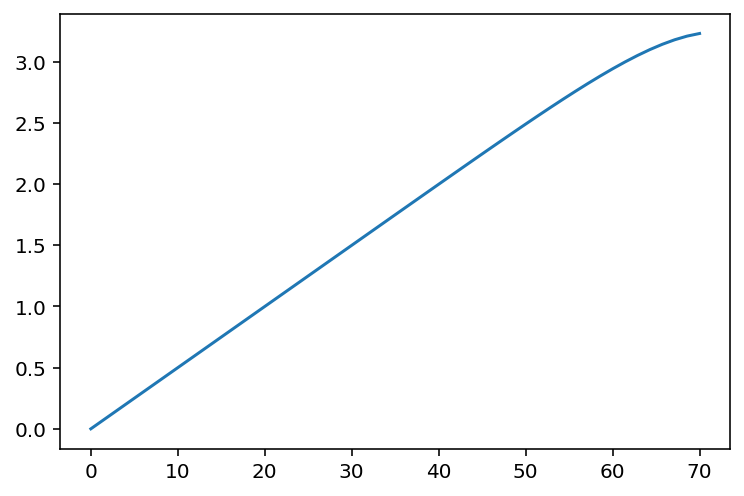

In [576]:
#Preallocation
VbF = np.zeros((I,J,Nz))
VbB = np.zeros((I,J,Nz))
VaF = np.zeros((I,J,Nz))
VaB = np.zeros((I,J,Nz))
c = np.zeros((I,J,Nz))
updiag = np.zeros((I*J,Nz))
lowdiag = np.zeros((I*J,Nz))
centdiag = np.zeros((I*J,Nz))
Ra = np.zeros((I,J,Nz))
AAi = [None]*Nz
BBi = [None]*Nz
b_dist = np.zeros((I,maxit))
a_dist = np.zeros((J,maxit))
ab_dist = np.zeros((I,J,maxit))
g = np.zeros((I,J,Nz))
dist = [None]*maxit


#INITIAL GUESS
v0 = (((1-xi)*w*zzz + ra*aaa + rb_neg*bbb)**(1-ga))/(1-ga)/rho
v = v0

#return at different points in state space
#matrix of liquid returns
Rb = rb_pos*(bbb>0) + rb_neg*(bbb<0)
raa = ra*np.ones((1,J))
#if ra>>rb, impose tax on ra*a at high a, otherwise some households
#accumulate infinite illiquid wealth (not needed if ra is close to or less than rb)
tau = 10
raa = ra*(1 - (1.33*amax/a[0,:])**(1-tau))
plt.plot(a[0,:], raa*a[0,:])
#matrix of illiquid returns
Ra[:,:,0] = np.dot( np.ones((I,1)), raa.reshape((1,J)))
Ra[:,:,1] = np.dot( np.ones((I,1)), raa.reshape((1,J)))

In [577]:
## FOC Function
def two_asset_kinked_FOC(pa,pb,a):
    return np.minimum(pa/pb - 1 + chi0, 0)*a/chi1 +  np.maximum(pa/pb - 1 - chi0,0)*a/chi1

## Kinked Cost Function Function
def two_asset_kinked_cost(d,a):
    return chi0*abs(d) + chi1*d**2/2*(np.maximum(a,10**(-5)))**(-1)

In [578]:
for n in range(0,maxit):
    V = v   
    #DERIVATIVES W.R.T. b
    # forward difference
    VbF[0:I-1,:,:] = (V[1:I,:,:]-V[0:I-1,:,:])/db
    VbF[I-1,:,:] = ((1-xi)*w*zzz[I-1,:,:] + Rb[I-1,:,:]*bmax)**(-ga) #state constraint boundary condition
    # backward difference
    VbB[1:I,:,:] = (V[1:I,:,:]-V[0:I-1,:,:])/db
    VbB[0,:,:] = ((1-xi)*w*zzz[0,:,:] + Rb[0,:,:]*bmin)**(-ga) #state constraint boundary condition

    #DERIVATIVES W.R.T. a
    # forward difference
    VaF[:,0:J-1,:] = (V[:,1:J,:]-V[:,0:J-1,:])/da
    # backward difference
    VaB[:,1:J,:] = (V[:,1:J,:]-V[:,0:J-1,:])/da
    
    #useful quantities
    c_B = np.maximum(VbB, 10**(-6))**(-1/ga)
    c_F = np.maximum(VbF, 10**(-6))**(-1/ga)
    dBB = two_asset_kinked_FOC(VaB,VbB,aaa)
    dFB = two_asset_kinked_FOC(VaB,VbF,aaa)
    #VaF(:,J,:) = VbB(:,J,:).*(1-ra.*chi1 - chi1*w*zzz(:,J,:)./a(:,J,:))
    dBF = two_asset_kinked_FOC(VaF,VbB,aaa)
    #VaF(:,J,:) = VbF(:,J,:).*(1-ra.*chi1 - chi1*w*zzz(:,J,:)./a(:,J,:))
    dFF = two_asset_kinked_FOC(VaF,VbF,aaa)
        
    #UPWIND SCHEME
    d_B = (dBF>0)*dBF + (dBB<0)*dBB
    #state constraints at amin and amax
    d_B[:,0,:] = (dBF[:,0,:]>10**(-12))*dBF[:,0,:] #make sure d>=0 at amax, don't use VaB(:,1,:)
    d_B[:,J-1,:] = (dBB[:,J-1,:]<-10**(-12))*dBB[:,J-1,:] #make sure d<=0 at amax, don't use VaF(:,J,:)
    d_B[0,0,:] = np.maximum(d_B[0,0,:],0)
    #split drift of b and upwind separately
    sc_B = (1-xi)*w*zzz + Rb*bbb - c_B
    sd_B = (-d_B - two_asset_kinked_cost(d_B,aaa))
    
    d_F = (dFF>0)*dFF + (dFB<0)*dFB
    #state constraints at amin and amax
    d_F[:,0,:] = (dFF[:,0,:]>10**(-12))*dFF[:,0,:] #make sure d>=0 at amin, don't use VaB(:,1,:)
    d_F[:,J-1,:] = (dFB[:,J-1,:]<-10**(-12))*dFB[:,J-1,:] #make sure d<=0 at amax, don't use VaF(:,J,:)
    
    #split drift of b and upwind separately
    sc_F = (1-xi)*w*zzz + Rb*bbb - c_F
    sd_F = (-d_F - two_asset_kinked_cost(d_F,aaa))
    sd_F[I-1,:,:] = np.minimum(sd_F[I-1,:,:],0)
    
    Ic_B = (sc_B < -10**(-12))
    Ic_F = (sc_F > 10**(-12))*(1- Ic_B)
    Ic_0 = 1 - Ic_F - Ic_B
    
    Id_F = (sd_F > 10**(-12))
    Id_B = (sd_B < -10**(-12))*(1- Id_F)
    Id_B[0,:,:] = 0
    Id_F[I-1,:,:] = 0
    Id_B[I-1,:,:] = 1 #don't use VbF at bmax so as not to pick up articial state constraint
    Id_0 = 1 - Id_F - Id_B
    
    c_0 = (1-xi)*w*zzz + Rb*bbb
  
    c = c_F*Ic_F + c_B*Ic_B + c_0*Ic_0
    u = c**(1-ga)/(1-ga)
    
    #CONSTRUCT MATRIX BB SUMMARING EVOLUTION OF b
    X = -Ic_B.astype(float)*sc_B/db -Id_B.astype(float)*sd_B/db
    Y = (Ic_B.astype(float)*sc_B - Ic_F.astype(float)*sc_F)/db + (Id_B.astype(float)*sd_B - Id_F.astype(float)*sd_F)/db
    Z = Ic_F.astype(float)*sc_F/db + Id_F.astype(float)*sd_F/db
    
    for i in range(0,Nz):
        centdiag[:,i] = np.reshape(Y[:,:,i],(I*J), order = "F")
    

    lowdiag[0:I-1,:] = X[1:I,0,:]
    updiag[1:I,:] = Z[0:I-1,0,:]
    for j in range(1,J):
        lowdiag[0:(j+1)*I,:] = np.vstack( (lowdiag[0:(j)*I,:], np.squeeze(X[1:I,j,:]), np.zeros((1,Nz)) ))
        updiag[0:(j+1)*I,:] = np.vstack( (updiag[0:(j)*I,:], np.zeros((1,Nz)), np.squeeze(Z[0:I-1,j,:])) )
    

     
    for nz in range(0,Nz):
        BBi[nz] = sparse.spdiags(centdiag[:,nz],0,I*J,I*J) + sparse.spdiags(updiag[:,nz],1,I*J,I*J) \
                + sparse.spdiags(np.insert(lowdiag[:,nz], -1, 0),-1,I*J,I*J)
    
    
    BB = sparse.vstack( (  sparse.hstack( ( BBi[0], sparse.csr_matrix( (I*J,I*J) )) ), \
                              sparse.hstack( (sparse.csr_matrix( (I*J,I*J) ), BBi[1]) ) ) )
    
    #CONSTRUCT MATRIX AA SUMMARIZING EVOLUTION OF a
    dB = Id_B*dBB + Id_F*dFB
    dF = Id_B*dBF + Id_F*dFF
    MB = np.minimum(dB,0)
    MF = np.maximum(dF,0) + xi*w*zzz + Ra*aaa
    MB[:,J-1,:] = xi*w*zzz[:,J-1,:] + dB[:,J-1,:] + Ra[:,J-1,:]*amax #this is hopefully negative
    MF[:,J-1,:] = 0
    chi = -MB/da
    yy =  (MB - MF)/da
    zeta = MF/da
    
    #MATRIX AAi
    for nz in range(0,Nz):
        #This will be the upperdiagonal of the matrix AAi
        AAupdiag = np.zeros(I) #This is necessary because of the peculiar way spdiags is defined.
        for j in range(0,J):
            AAupdiag = np.concatenate( (AAupdiag, zeta[:,j,nz]), axis=0 )
        
        
        #This will be the center diagonal of the matrix AAi
        AAcentdiag = yy[:,0,nz]
        for j in range(1,J-1):
            AAcentdiag = np.concatenate( (AAcentdiag, yy[:,j,nz]), axis=0 )
        
        AAcentdiag = np.concatenate( (AAcentdiag, yy[:,J-1,nz]), axis=0 )
        
        #This will be the lower diagonal of the matrix AAi
        AAlowdiag = chi[:,1,nz]
        for j in range(2,J):
            AAlowdiag = np.concatenate( (AAlowdiag, chi[:,j,nz]), axis=0 )
        
        
        #Add up the upper, center, and lower diagonal into a sparse matrix
        AAi[nz] = sparse.spdiags(AAcentdiag,0,I*J,I*J)+sparse.spdiags(AAlowdiag,-I,I*J,I*J) \
                    + sparse.spdiags(AAupdiag,I,I*J,I*J)
    
    
    AA = sparse.vstack( (  sparse.hstack( ( AAi[0], sparse.csr_matrix( (I*J,I*J) )) ),
                          sparse.hstack( (sparse.csr_matrix( (I*J,I*J) ), AAi[1]) ) ))
    
    A = AA.tocsr() + BB.tocsr() + Bswitch.tocsr()
    

    if np.max(abs(sparse.csr_matrix.sum(A, axis=1))) > 10**(-9):
        print('Improper Transition Matrix')
        break
    
    
    B = (1/Delta + rho)*sparse.eye(I*J*Nz) - A
    
    u_stacked = np.reshape(u, (I*J*Nz,1), order = 'F')
    V_stacked = np.reshape(V, (I*J*Nz,1), order = 'F')
    
    vec = u_stacked + V_stacked/Delta
    
    V_stacked = sparse.linalg.spsolve(B,vec) #SOLVE SYSTEM OF EQUATIONS
        
    V = np.reshape(V_stacked,(I,J,Nz), order = 'F')
    
    
    Vchange = V - v
    v = V
    
    b_dist[:,n] = np.amax(abs(Vchange[:,:,1]), axis = 1)
    a_dist[:,n] = np.amax(np.amax(abs(Vchange), axis = 2), axis = 0)
    ab_dist[:,:,n] = np.amax(abs(Vchange), axis = 2)
   
    dist[n] = np.amax(abs(Vchange))
    print('Value Function, Iteration ', n ,', max Vchange = ', dist[n])
    if dist[n] < crit:
        print('Value Function Converged, Iteration = %1.2f' % n)
        
        break
    


Value Function, Iteration  0 , max Vchange =  1.2102615494623867
Value Function, Iteration  1 , max Vchange =  0.4430673006854917
Value Function, Iteration  2 , max Vchange =  0.18098712132335226
Value Function, Iteration  3 , max Vchange =  0.041864476848596066
Value Function, Iteration  4 , max Vchange =  0.009299617419777029
Value Function, Iteration  5 , max Vchange =  0.0012957921797314143
Value Function, Iteration  6 , max Vchange =  0.00018763692150525202
Value Function, Iteration  7 , max Vchange =  2.6379127407105685e-05
Value Function, Iteration  8 , max Vchange =  3.661844832025807e-06
Value Function Converged, Iteration = 8.00


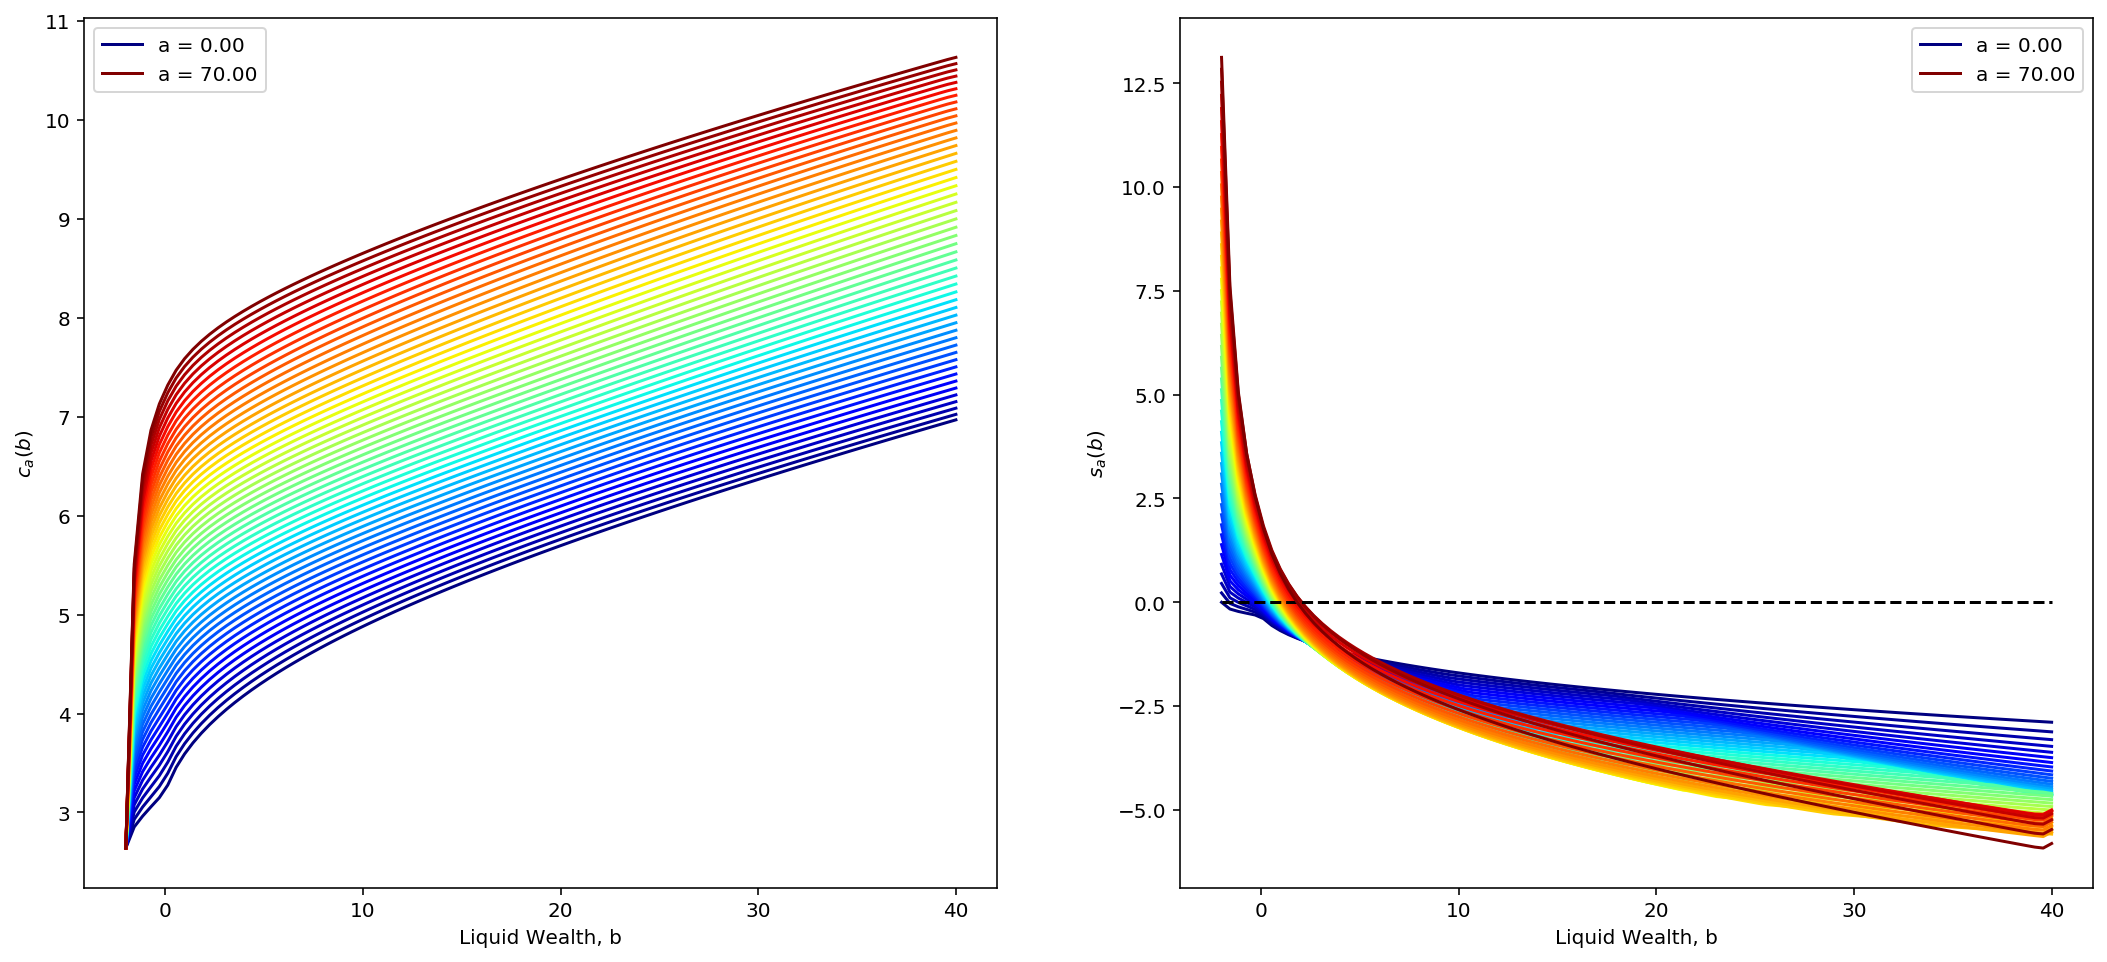

In [579]:
d = Id_B*d_B + Id_F*d_F
m = d + xi*w*zzz + Ra*aaa
s = (1-xi)*w*zzz + Rb*bbb - d - two_asset_kinked_cost(d,aaa) - c

sc = (1-xi)*w*zzz + Rb*bbb - c
sd = - d - two_asset_kinked_cost(d,aaa)


fig, ax = plt.subplots(1,2, figsize = (18,8))

# for i in range(0,I):
#     ax[0,0].plot(a.reshape(J), d[i,:,0], lw = 0.7)
#     ax[0,0].plot(a.reshape(J), np.zeros(J),'--', color = 'k')
#     ax[0,0].set_xlabel('Illiquid Wealth, a')

# ax[0,1].plot(a, m[:,:,0], a, np.zeros((J,1)),'k--')
# ax[0,1].set_xlabel('Illiquid Wealth, a')


# Plotting policy functions under bad state
n = 50
colors = plt.cm.jet(np.linspace(0,1,n))

ax[0].plot(b.reshape(I), c[:,0,0], label = 'a = %1.2f' % a[0,0], color = colors[0])
for j in range(1,J-1):
    ax[0].plot(b.reshape(I), c[:,j,0], color = colors[j])
ax[0].plot(b.reshape(I), c[:,J-1,0], label = 'a = %1.2f' % a[0,-1], color = colors[J-1])
ax[0].set_xlabel('Liquid Wealth, b')
ax[0].legend()
ax[0].set_ylabel(r'$c_a(b)$')

ax[1].plot(b.reshape(I), s[:,0,0], label = 'a = %1.2f' % a[0,0], color = colors[0])
for j in range(1,J-1):
    ax[1].plot(b.reshape(I), s[:,j,0], color = colors[j])
ax[1].plot(b.reshape(I), np.zeros(I),'k--')
ax[1].plot(b.reshape(I), s[:,J-1,0], label = 'a = %1.2f' % a[0,-1], color = colors[J-1])
ax[1].set_xlabel('Liquid Wealth, b')
ax[1].legend()
ax[1].set_ylabel(r'$s_a(b)$')

plt.show()

In [580]:
###########################
# STATIONARY DISTRIBUTION #
###########################
# RECONSTRUCT TRANSITION MATRIX WITH SIMPLER UPWIND SCHEME
X = -np.minimum(s,0)/db
Y = np.minimum(s,0)/db - np.maximum(s,0)/db
Z = np.maximum(s,0)/db

for i in range(0,Nz):
    centdiag[:,i] = np.reshape(Y[:,:,i],(I*J), order = 'F')


lowdiag[0:I-1,:] = X[1:I,0,:]
updiag[1:I,:] = Z[0:I-1,0,:]
for j in range(1,J):
    lowdiag[0:(j+1)*I,:] = np.vstack( (lowdiag[0:(j)*I,:], np.squeeze(X[1:I,j,:]), np.zeros((1,Nz)) ))
    updiag[0:(j+1)*I,:] = np.vstack( (updiag[0:(j)*I,:], np.zeros((1,Nz)), np.squeeze(Z[0:I-1,j,:])) )

    
    
for nz in range(0,Nz):
    BBi[nz] = sparse.spdiags(centdiag[:,nz],0,I*J,I*J) + sparse.spdiags(updiag[:,nz],1,I*J,I*J) \
                + sparse.spdiags(np.insert(lowdiag[:,nz], -1, 0),-1,I*J,I*J) 

BB = sparse.vstack( (  sparse.hstack( ( BBi[0], sparse.csr_matrix( (I*J,I*J) )) ), \
                              sparse.hstack( (sparse.csr_matrix( (I*J,I*J) ), BBi[1]) ) ) )
    

#CONSTRUCT MATRIX AA SUMMARIZING EVOLUTION OF a
chi = -np.minimum(m,0)/da
yy =  np.minimum(m,0)/da - np.maximum(m,0)/da
zeta = np.maximum(m,0)/da


#MATRIX AAi
for nz in range(0,Nz):
    #This will be the upperdiagonal of the matrix AAi
    AAupdiag = np.zeros(I) #This is necessary because of the peculiar way spdiags is defined.
    for j in range(0,J):
        AAupdiag = np.concatenate( (AAupdiag, zeta[:,j,nz]), axis=0 )


    #This will be the center diagonal of the matrix AAi
    AAcentdiag = yy[:,0,nz]
    for j in range(1,J-1):
        AAcentdiag = np.concatenate( (AAcentdiag, yy[:,j,nz]), axis=0 )

    AAcentdiag = np.concatenate( (AAcentdiag, yy[:,J-1,nz]), axis=0 )

    #This will be the lower diagonal of the matrix AAi
    AAlowdiag = chi[:,1,nz]
    for j in range(2,J):
        AAlowdiag = np.concatenate( (AAlowdiag, chi[:,j,nz]), axis=0 )


    #Add up the upper, center, and lower diagonal into a sparse matrix
    AAi[nz] = sparse.spdiags(AAcentdiag,0,I*J,I*J)+sparse.spdiags(AAlowdiag,-I,I*J,I*J) \
                + sparse.spdiags(AAupdiag,I,I*J,I*J)


AA = sparse.vstack( (  sparse.hstack( ( AAi[0], sparse.csr_matrix( (I*J,I*J) )) ),
                      sparse.hstack( (sparse.csr_matrix( (I*J,I*J) ), AAi[1]) ) ))

A = AA.tocsr() + BB.tocsr() + Bswitch.tocsr()
    

M = I*J*Nz
AT = A.T
# Fix one value so matrix isn't singular:
vec = np.zeros((M,1))
iFix = 1657
vec[iFix]=.01
AT[iFix,:] = np.hstack( (np.zeros((1,iFix-1)), np.ones((1,1)), np.zeros((1,M-iFix)) ) )

# Solve system:
g_stacked = sparse.linalg.spsolve(AT,vec)
g_sum = np.dot(g_stacked.T, np.ones( (M,1) )*da*db)
g_stacked = g_stacked/g_sum


g[:,:,0] = np.reshape(g_stacked[0:I*J],(I,J), order = 'F')
g[:,:,1] = np.reshape(g_stacked[I*J:I*J*2],(I,J), order = 'F')

/Users/joaobduarte/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


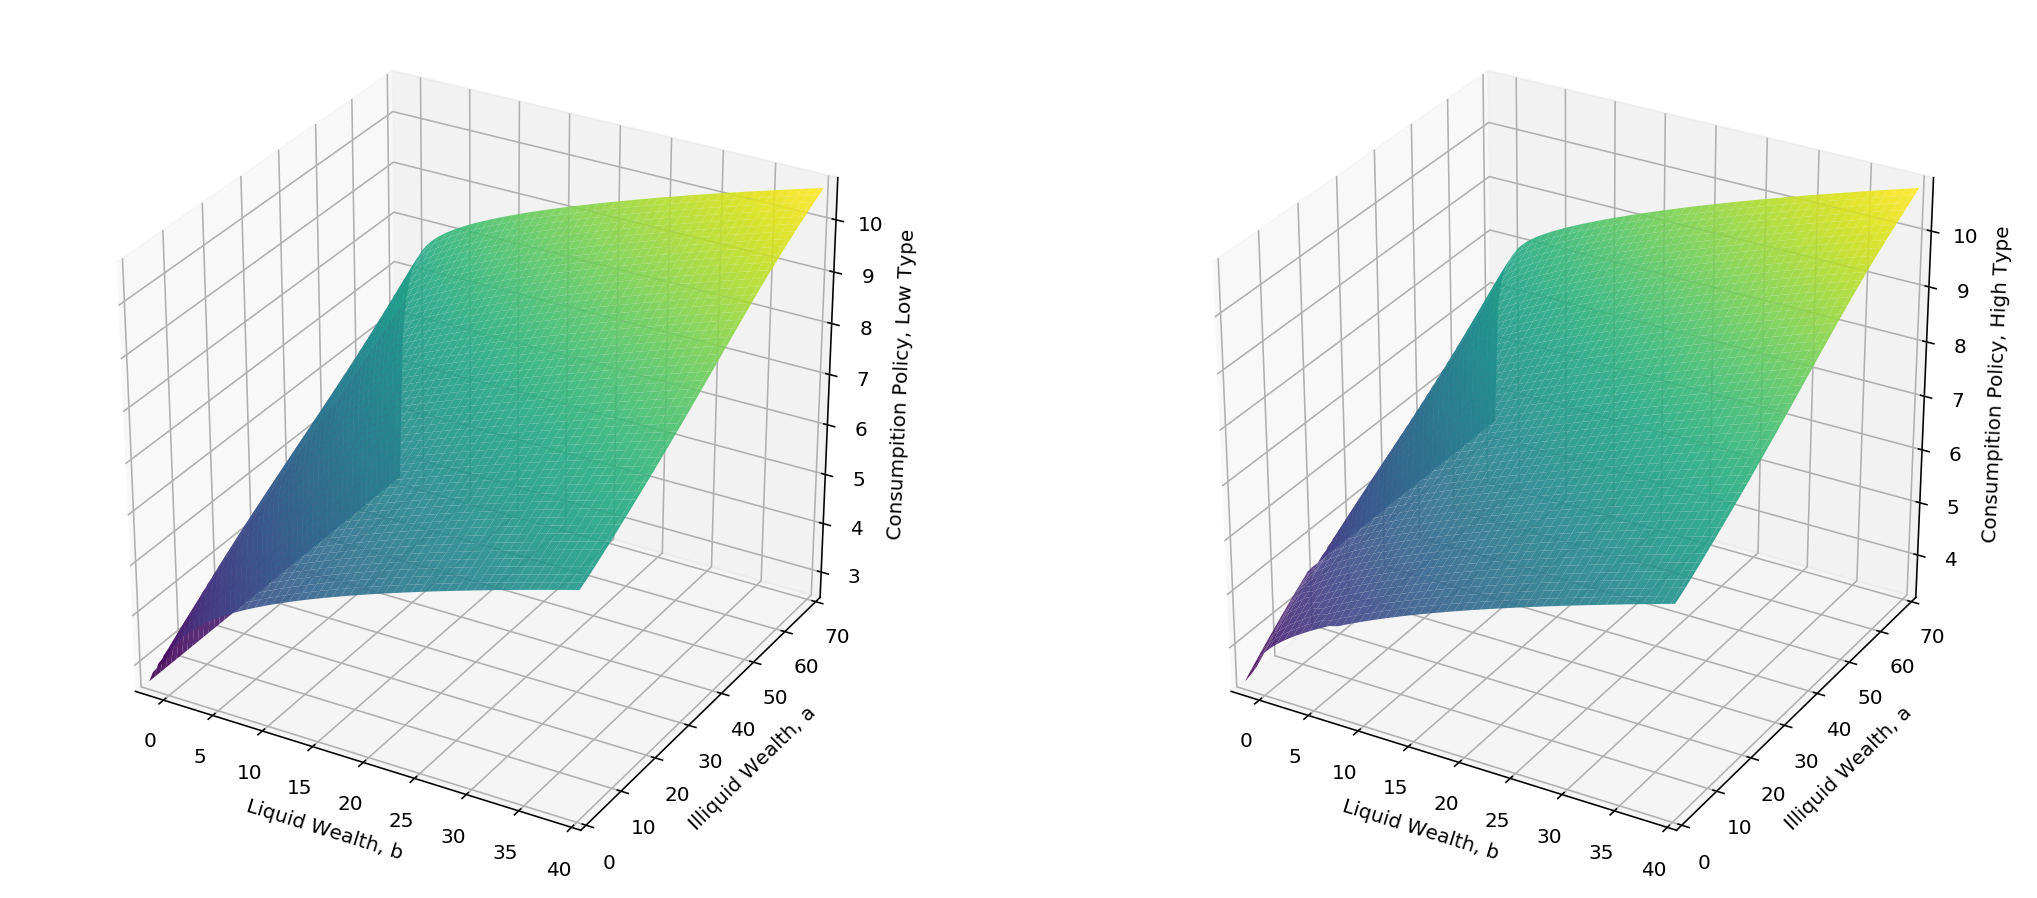

In [586]:

###########
# FIGURES #
###########


bgrid, agrid = np.meshgrid(b, a)
        
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, c[:,:,0], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_zlabel('Consumpition Policy, Low Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))


ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, c[:,:,1], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_zlabel('Consumpition Policy, High Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))

plt.show()


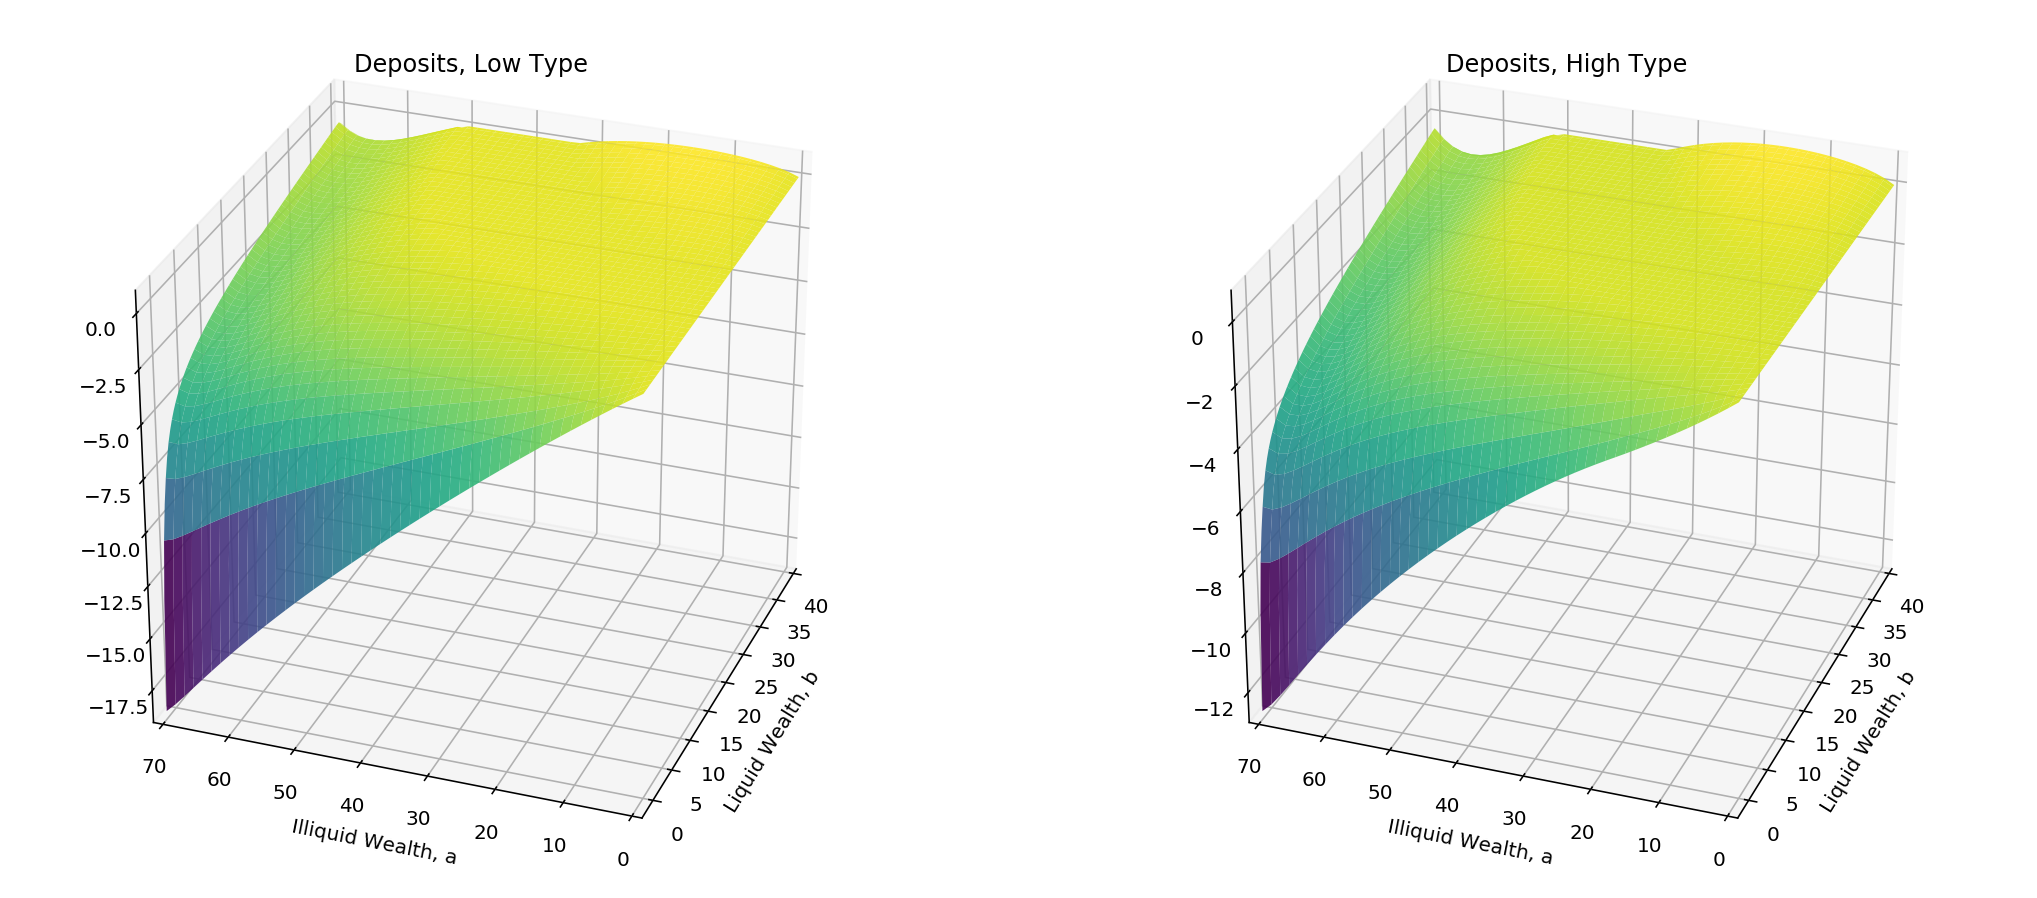

In [603]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, d[:,:,0], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Deposits, Low Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))
ax.view_init(30, 200)

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, d[:,:,1], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Deposits, High Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))
ax.view_init(30, 200)

plt.show()

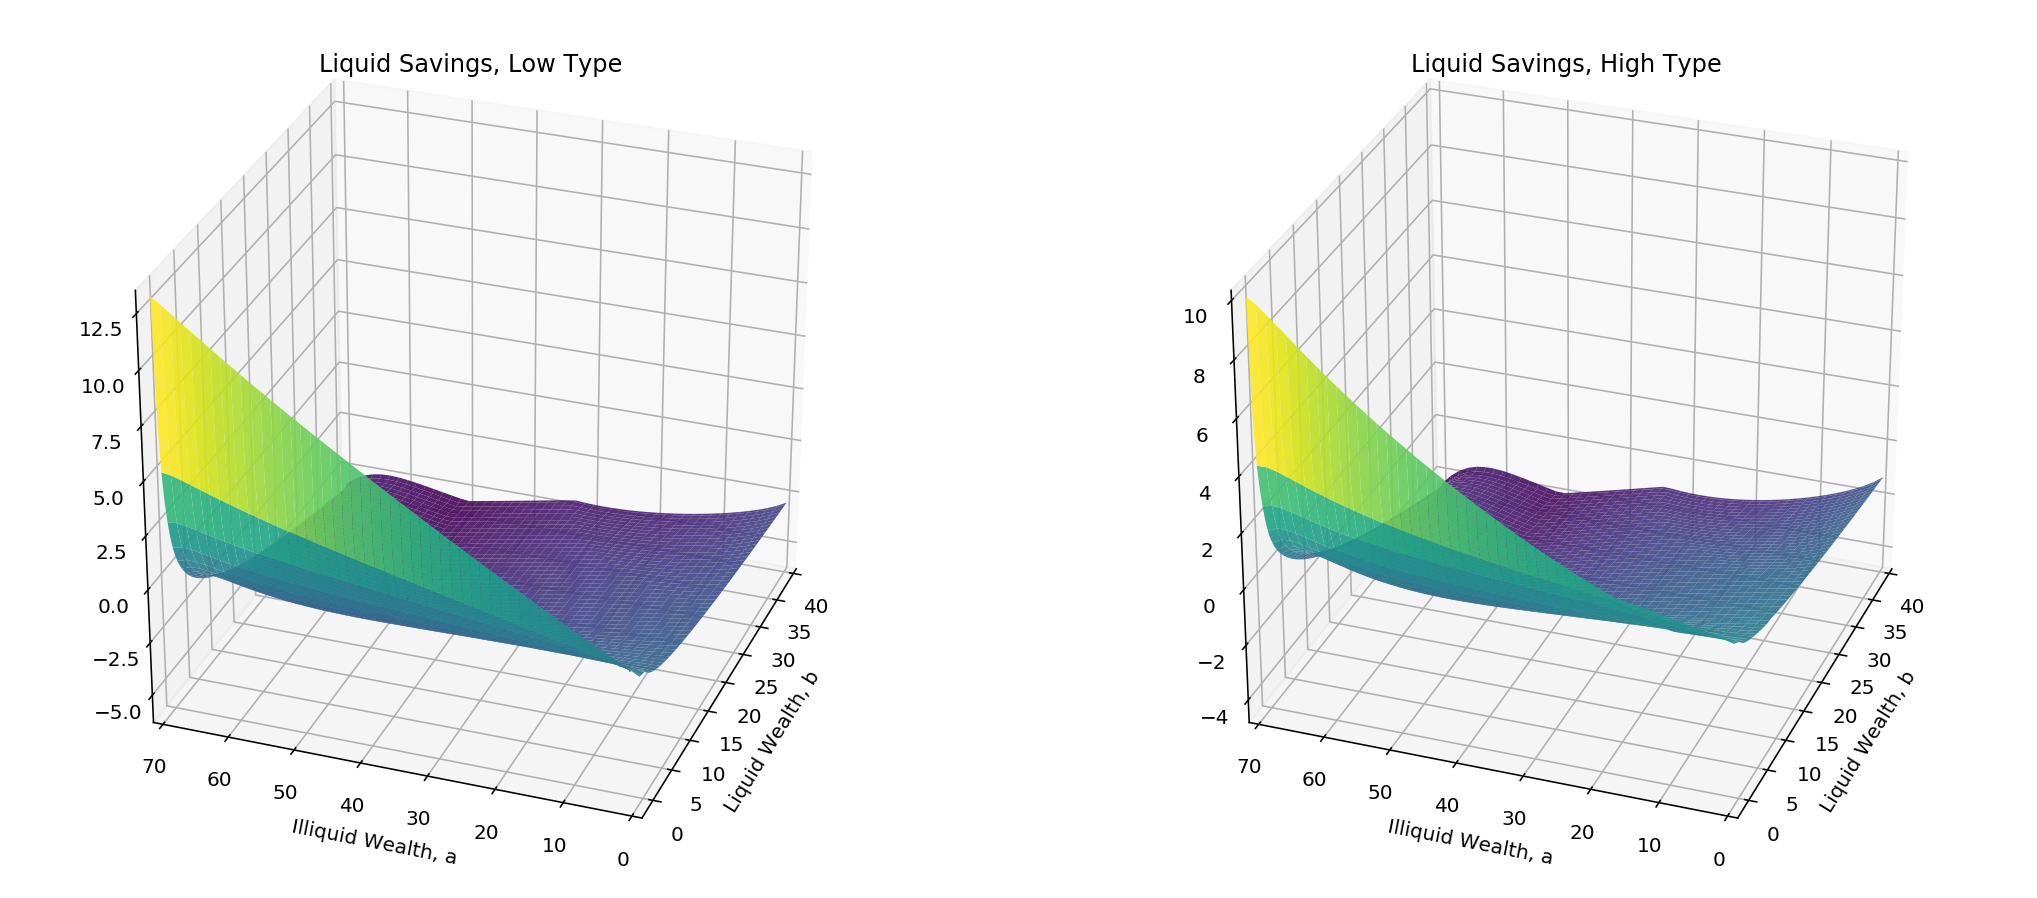

In [604]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, s[:,:,0], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Liquid Savings, Low Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))
ax.view_init(30, 200)

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, s[:,:,1], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Liquid Savings, High Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))
ax.view_init(30, 200)

plt.show()

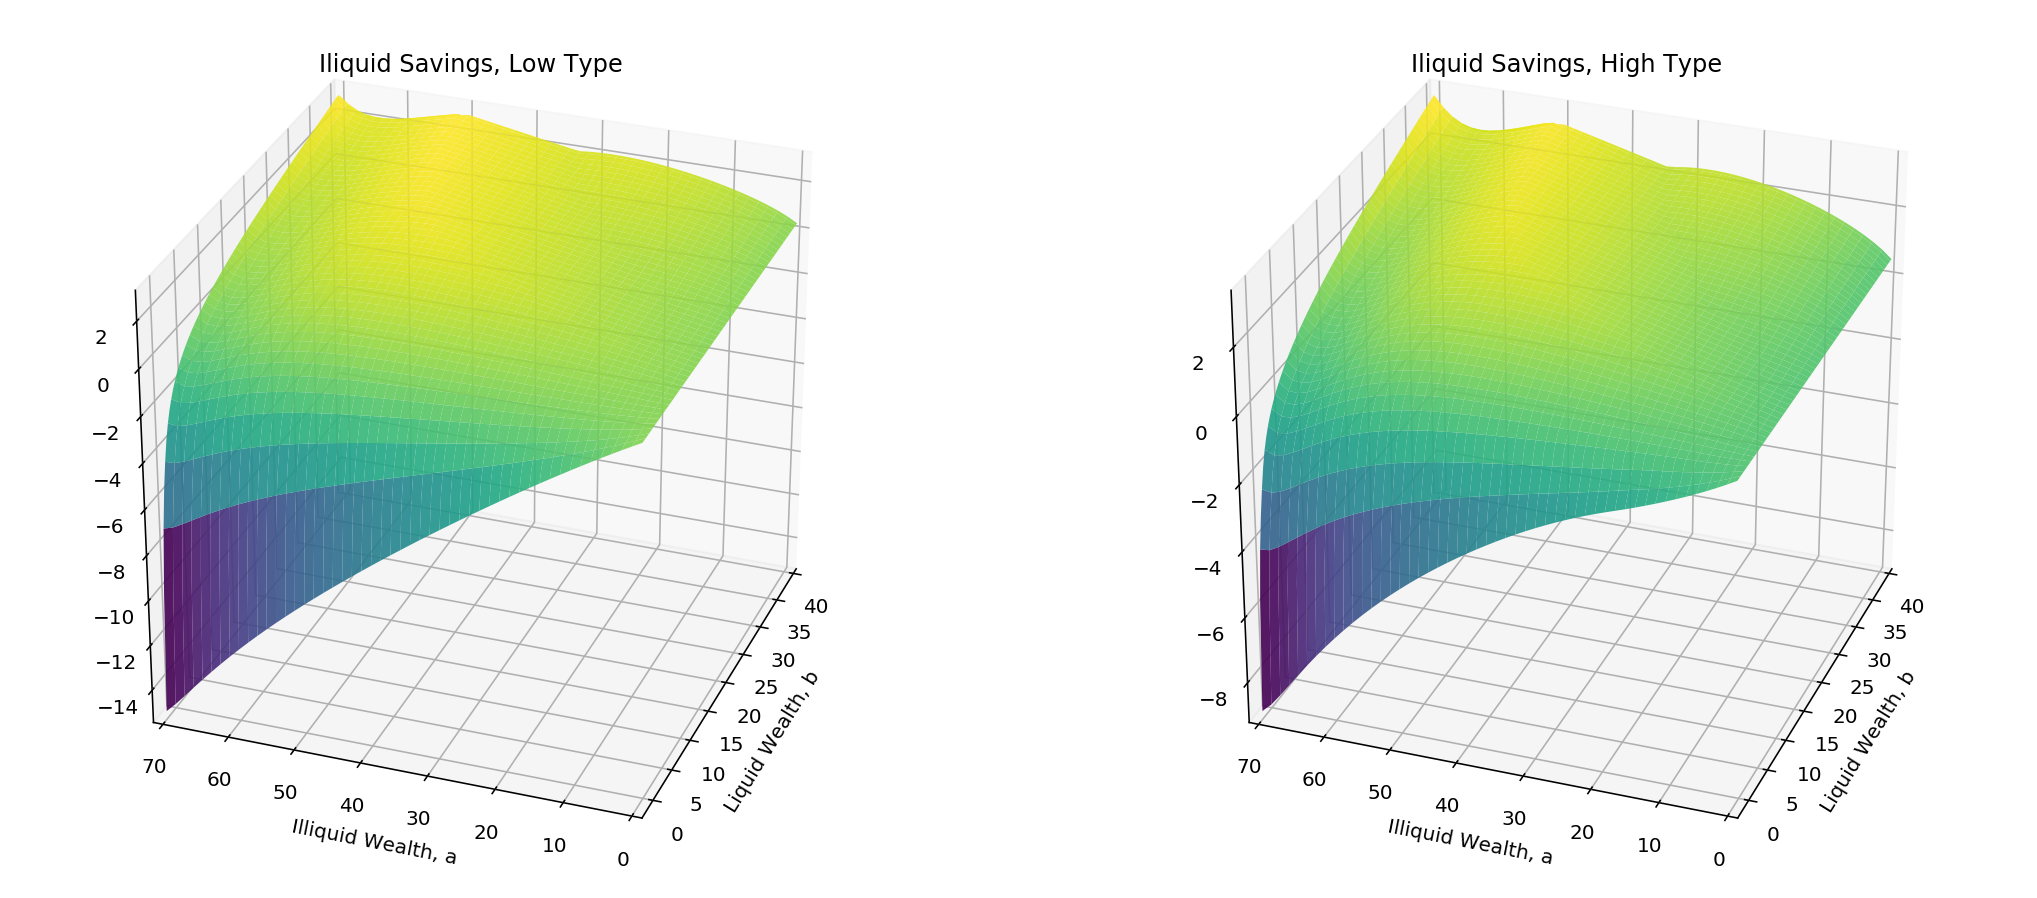

In [605]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, m[:,:,0], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Iliquid Savings, Low Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))
ax.view_init(30, 200)

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(bgrid.T, agrid.T, m[:,:,1], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Iliquid Savings, High Type')
ax.set_xlim((bmin, bmax))
ax.set_ylim((amin, amax))
ax.view_init(30, 200)

plt.show()

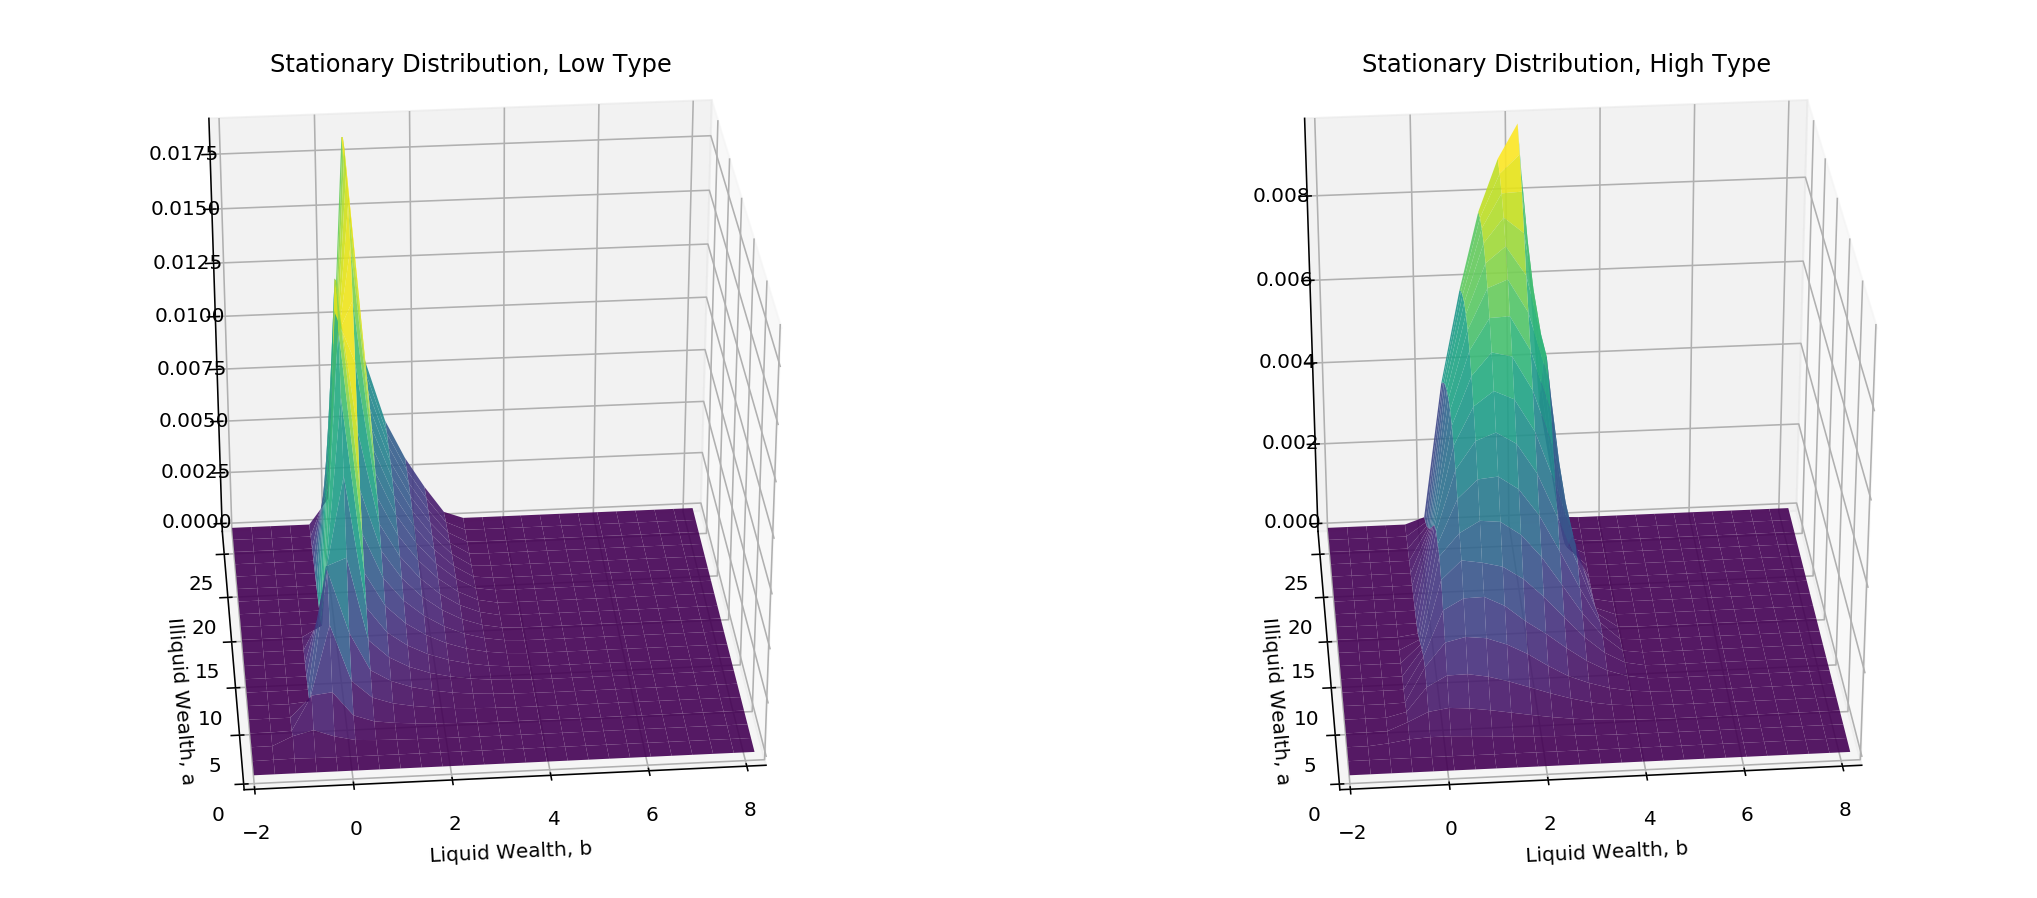

In [634]:
icut = 25
jcut = 20
bcut = b[0:icut,0]
acut = a[0,0:jcut]
gcut = g[0:icut,0:jcut,:]

bgridcut, agridcut = np.meshgrid(bcut, acut)

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(bgridcut.T, agridcut.T, gcut[:,:,0], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Stationary Distribution, Low Type')
ax.set_xlim((bmin, bcut[-1]))
ax.set_ylim((amin, acut[-1]))
ax.view_init(30, -95)

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(bgridcut.T, agridcut.T, gcut[:,:,1], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel(r'Liquid Wealth, b')
ax.set_ylabel(r'Illiquid Wealth, a')
ax.set_title('Stationary Distribution, High Type')
ax.set_xlim((bmin, bcut[-1]))
ax.set_ylim((amin, acut[-1]))
ax.view_init(30, -95)

plt.show()

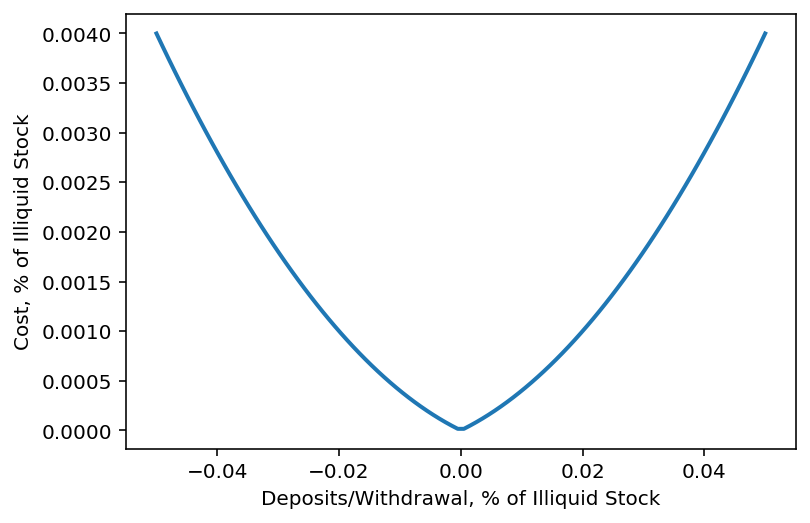

In [636]:
dgrid = np.linspace(-0.05,0.05,100)

plt.plot(dgrid,two_asset_kinked_cost(dgrid,1), lw = 2)
plt.ylabel('Cost, % of Illiquid Stock')
plt.xlabel('Deposits/Withdrawal, % of Illiquid Stock')
plt.show()